In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from tqdm.auto import tqdm

%matplotlib inline

In [2]:
# Seed for random functions
SEED = 1

## Dataset Preparation

In [3]:
# Inspect the data
df = pd.read_csv('../data/bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# Feature data types
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [5]:
# Relevant numerical and categorical features
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [6]:
# Split dataset into train/valid/test sets (60-20-20 split)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=(0.2/0.8), random_state=SEED)

# Target variables
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

# Remove target variable from DataFrames
del df_train['y']
del df_val['y']
del df_test['y']

# Encode target variable
y_train = (y_train == 'yes').astype(int)
y_val = (y_val == 'yes').astype(int)
y_test = (y_test == 'yes').astype(int)

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

In [7]:
print('%s: %.3f' % ('balance', roc_auc_score(y_train, df_train['balance'].values)))
print('%s: %.3f' % ('day', roc_auc_score(y_train, -df_train['day'].values)))
print('%s: %.3f' % ('duration', roc_auc_score(y_train, df_train['duration'].values)))
print('%s: %.3f' % ('previous', roc_auc_score(y_train, df_train['previous'].values)))

balance: 0.589
day: 0.526
duration: 0.815
previous: 0.599


**Answer**: `duration` has the highest AUC among the four numerical variables.

## Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [8]:
# Create train/valid dicts for DictVectorizer
train_dict = df_train[categorical + numerical].to_dict(orient='records')
val_dict = df_val[categorical + numerical].to_dict(orient='records')

# Create DV, fit on train set, and obtain train/valid feature vectors
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Train LogisticRegression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=SEED)
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8999780109216243

**Answer**: The AUC of this model on the validation set is 0.89.

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.265
- 0.465
- 0.665
- 0.865

/tmp/ipykernel_77672/415882134.py:14: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / pred_pos


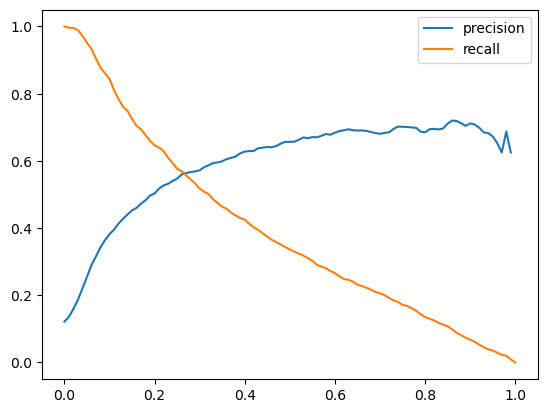

In [9]:
# Thresholds from 0 to 1 at .01 increments
thresholds = np.linspace(0.0, 1.0, 101)

# Store precision and recall values
precisions = []
recalls = []

# Compute precision and recall for each threshold
for t in thresholds:
    tp = ((y_pred >= t).astype(int) & y_val).sum()
    pred_pos = (y_pred >= t).sum()
    actual_pos = y_val.sum()

    precision = tp / pred_pos
    recall = tp / actual_pos

    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall as a function of threshold
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.legend()
plt.show()

In [10]:
# Compute the point of intersection
thresholds[np.array(precisions).round(2) == np.array(recalls).round(2)][0]

0.27

**Answer**: The precision and recall curves intersect at t=0.265 or t=0.27.

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1=2\cdot\frac{P\cdot R}{P+R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

/tmp/ipykernel_77672/224434616.py:15: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / pred_pos


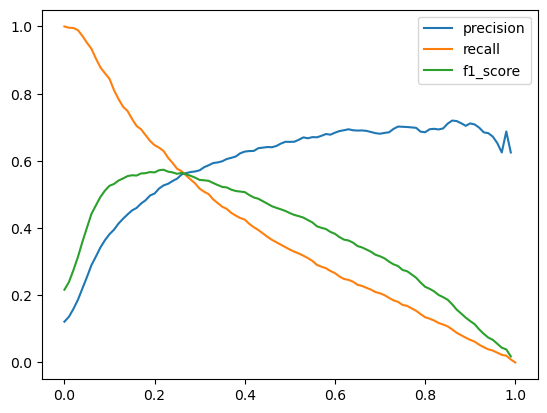

In [11]:
# Thresholds from 0 to 1 at .01 increments
thresholds = np.linspace(0.0, 1.0, 101)

# Store precision, recall, and F1 score values
precisions = []
recalls = []
f1_scores = []

# Compute precision, recall, and F1 score for each threshold
for t in thresholds:
    tp = ((y_pred >= t).astype(int) & y_val).sum()
    pred_pos = (y_pred >= t).sum()
    actual_pos = y_val.sum()

    precision = tp / pred_pos
    recall = tp / actual_pos
    f1_score = 2 * (precision * recall) / (precision + recall)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Plot precision, recall, and F1 score as a function of threshold
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.plot(thresholds, f1_scores, label='f1_score')
plt.legend()
plt.show()

In [12]:
# Find threshold with maximal F1 score
f1_scores_no_nan = np.array(f1_scores)[:-1]
max_idx = f1_scores_no_nan.argmax()
thresholds[max_idx]

0.22

**Answer**: The F1 score is maximal at t=0.22.

## Question 5: 5-Fold CV

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```python
KFold(n_splits=5, shuffle=True, random_state=1)
```
- Iterate over different folds of `df_full_train`
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [13]:
# Utility functions for training and prediction
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=SEED)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [14]:
# Number of folds k
n_splits = 5

# Holds AUC scores
scores = []

# Create KFold object with n_splits and shuffle=True
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Iterate over the folds, train model, and record AUC
for train_idx, valid_idx in tqdm(kfold.split(df_full_train), total=n_splits):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[valid_idx]

    y_train = (df_train.y.values == 'yes').astype(int)
    y_val = (df_val.y.values == 'yes').astype(int)

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('AUC (C=1.0): %.3f +- %.3f' % (np.mean(scores), np.std(scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

AUC (C=1.0): 0.906 +- 0.006


**Answer**: The standard deviation across folds (C=1.0) is 0.006.

## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

- Iterate over the following `C` values: `[0.000001, 0.001, 1]`
- Initialize `KFold` with the same parameters as previously
- Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [15]:
# Number of folds k
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    # Holds AUC scores
    scores = []

    # Create KFold object with n_splits and shuffle=True
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    
    # Iterate over the folds, train model, and record AUC
    for train_idx, valid_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[valid_idx]
    
        y_train = (df_train.y.values == 'yes').astype(int)
        y_val = (df_val.y.values == 'yes').astype(int)
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('AUC (C=%s): %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

AUC (C=1e-06): 0.701 +- 0.009
AUC (C=0.001): 0.861 +- 0.007
AUC (C=1): 0.906 +- 0.006


**Answer**: C=1.0 leads to the best average score.